The dataset is taken from Kaggle. StackSample Dataset consists of text of 10% of questions and answers from the Stack Overflow programming Q&A website. 

Questions.csv contains the title, body, creation date, closed date (if applicable), score, and owner ID for all non-deleted Stack Overflow questions whose Id is a multiple of 10 and has 1264216 rows

Tags.csv contains the tags on each of these questions and has 3750994 rows

### Importing libraries

In [96]:
# Importing libraries

import numpy as np
import pandas as pd

import re
import regex

import math

# html to text
from bs4 import BeautifulSoup

import nltk
# Text Preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Data Visualization
import matplotlib.pyplot as plt

# Multilabel Classificatiion
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline and Feature Union
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Train-test split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

# Supervised ML models
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Taking one class at a time an then classifying one class vs rest classes
from sklearn.multiclass import OneVsRestClassifier

# Performance evaluation metric
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [176]:
# Ignore warnings
pd.options.mode.chained_assignment = None

### Load data

In [47]:
# Load questions dataset
df_ques_original = pd.read_csv('Questions.csv',encoding='latin1')

In [48]:
# Making copy of questions dataset to avoid changes in the original
df_ques = df_ques_original.copy()

In [49]:
# Summary for questions dataset
df_ques.info()

# Total 1264216 rows and 7 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [50]:
# Removing unwanted columns from questions dataset
df_ques.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [51]:
df_ques.head()

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [52]:
# Load tags dataset
df_tags_original = pd.read_csv('Tags.csv')

In [53]:
# Making a copy of tags dataset to avoid changes in the original
df_tags = df_tags_original.copy()

In [54]:
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [55]:
# Summary for tags dataset
df_tags.info()

# Total 3750994 rows and 2 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [56]:
# Frequency distribution for all the tags
freqDict = nltk.FreqDist(df_tags['Tag'])
freqDict

FreqDist({'javascript': 124155, 'java': 115212, 'c#': 101186, 'php': 98808, 'android': 90659, 'jquery': 78542, 'python': 64601, 'html': 58976, 'c++': 47591, 'ios': 47009, ...})

In [57]:
# 10 tags with highest occurences
df_tags.Tag.value_counts()[:10]

javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64

### Data Visualization

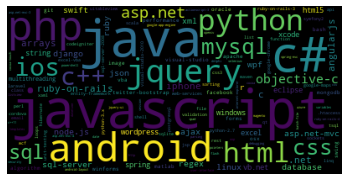

In [58]:
# Wordcloud for tags
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(freqDict)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

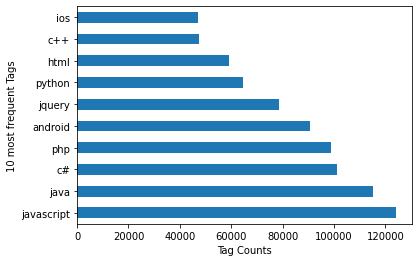

In [59]:
# Bar graph for 10 tags with highest occurences
df_tags['Tag'].value_counts()[:10].plot(kind='barh')
plt.xlabel('Tag Counts')
plt.ylabel('10 most frequent Tags')
plt.show

### Preprocessing tags

In [60]:
# Changing the datatype of tags to str and grouping them with IDs as same question can have multiple tags
df_tags['Tag'] = df_tags['Tag'].astype(str)
grouped_tags = df_tags.groupby("Id")['Tag'].apply(lambda df_tags: ' '.join(df_tags))
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [61]:
# Checking shape for grouped_tags
grouped_tags.shape

(1264216,)

In [62]:
# Merging tags with questions dataset based on Id
df_ques = df_ques.merge(grouped_tags, on='Id')
df_ques.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [63]:
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264216 entries, 0 to 1264215
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Id      1264216 non-null  int64 
 1   Score   1264216 non-null  int64 
 2   Title   1264216 non-null  object
 3   Body    1264216 non-null  object
 4   Tag     1264216 non-null  object
dtypes: int64(2), object(3)
memory usage: 57.9+ MB


In [64]:
# Taking rows with question score > 5 
df_ques = df_ques[df_ques['Score']>5]

In [65]:
# Only taking rows with score > 5 from questions dataset
df_ques.shape

# Number of rows reduced to 72950

(72950, 5)

In [66]:
# Removing unwanted columns
df_ques.drop(columns=['Id', 'Score'], inplace=True)

In [67]:
df_ques.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [68]:
# Resulting count of all tags and unique tags in Tag column
df_ques['Tags'] = df_ques['Tag'].apply(lambda x: x.split())
all_tags = [item for sublist in df_ques['Tags'].values for item in sublist]
unique_tags = set(all_tags)
print("Count of all tags: ", len(all_tags))
print("Count of unique tags: ", len(unique_tags))

Count of all tags:  224129
Count of unique tags:  14883


In [69]:
# Frequency distribution of tags
flat_list = [item for sublist in df_ques['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)
keywords

FreqDist({'c#': 6907, 'java': 6862, 'javascript': 5560, 'android': 5052, 'python': 4442, 'c++': 4369, 'php': 3024, 'jquery': 2770, '.net': 2705, 'ios': 2685, ...})

In [70]:
# Considering top 100 most common tags
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [275]:
# Taking 100 top tags as labels
tags_features[:15]

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c']

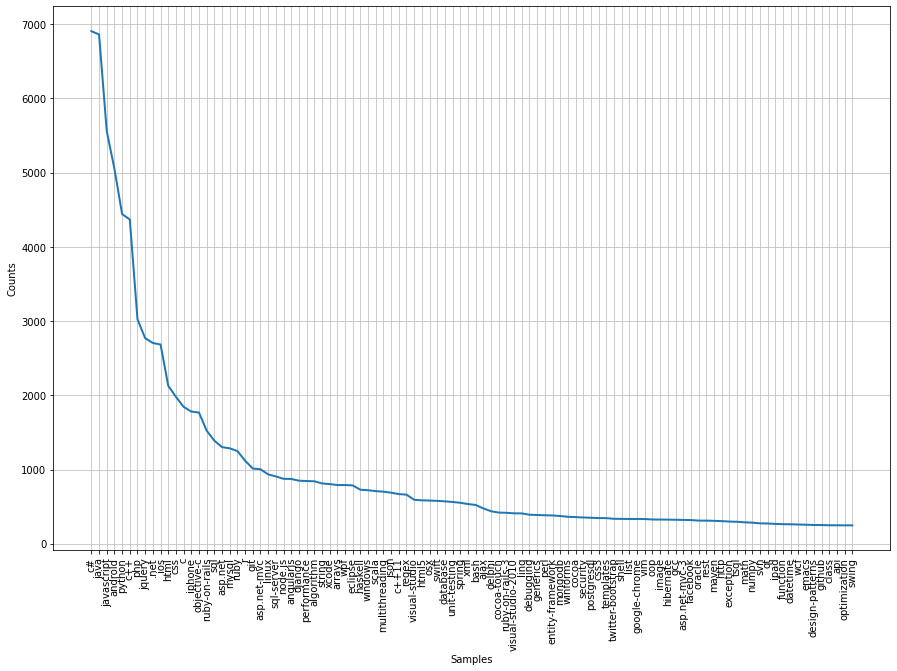

In [72]:
# Visualizing counts for 100 most common tags
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [73]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [74]:
# Keeping tags in the dataset only with 100 most common tags
df_ques['Tags'] = df_ques['Tags'].apply(lambda x: most_common(x))
df_ques['Tags'] = df_ques['Tags'].apply(lambda x: x if len(x)>0 else None)

In [75]:
df_ques.shape

(72950, 4)

In [76]:
# Removing rows with null values in tags column
df_ques.dropna(subset=['Tags'], inplace=True)

In [77]:
df_ques.drop(columns='Tag', inplace=True)

In [78]:
df_ques.shape

(63167, 3)

In [79]:
df_ques.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


### Data Preprocessing for Body and Title columns

In [80]:
# Using english stopwords
stopWord = stopwords.words('english')

In [81]:
# Lemmatization
lemma = nltk.WordNetLemmatizer()

In [82]:
# Text preprocessing
def processing(text):
    
    # html to text
    text = BeautifulSoup(text).get_text()
    
    # lowering text
    text = text.lower()
    
    # transforming abbreviations
    text = re.sub("what's", "what is ", text)
    text = re.sub("it's", "it is ", text)
    text = re.sub("\'s", " ", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not ", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'scuse", " excuse ", text)
    text = re.sub('\s+', ' ', text)
    
    #remove numbers
    text = re.sub(r'[0-9]+', '', text)
    
    # removing stopwords
    text = text.split()                                                                                                                         
    text = " ".join([word for word in text if not word in stopWord])
    
    # removing punctuation with some exceptions
    text = " ".join([regex.sub(r'c#(*SKIP)(*FAIL)|c\++(*SKIP)(*FAIL)|.net(*SKIP)(*FAIL)|asp.net(*SKIP)(*FAIL)|ruby-on-rails(*SKIP)(*FAIL)|objective-c(*SKIP)(*FAIL)|[^\w\s]+', '', text)])
    
    # Lemmatization
    text = nltk.word_tokenize(text)
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)

    return text

In [83]:
# Text preprocessing for Body column
df_ques['PreprocessedBody'] = df_ques['Body'].apply(lambda x: processing(x)) 
df_ques.head()

,Title,Body,Tags,PreprocessedBody
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn],really good tutorial explaining branching merg...
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]",anyone got experience creating sqlbased asp.ne...
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm],something pseudosolved many time never quite f...
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]",little game written c # us database backend tr...
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]",working collection class used video playback r...


In [84]:
# Text preprocessing for Title column
df_ques['PreprocessedTitle'] = df_ques['Title'].apply(lambda x: processing(x)) 
df_ques.head()

,Title,Body,Tags,PreprocessedBody,PreprocessedTitle
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn],really good tutorial explaining branching merg...,good branching merging tutorial tortoisesvn
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]",anyone got experience creating sqlbased asp.ne...,asp.net site map
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm],something pseudosolved many time never quite f...,function creating color wheel
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]",little game written c # us database backend tr...,adding scripting functionality .net application
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]",working collection class used video playback r...,use nested class case


In [85]:
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63167 entries, 1 to 1264205
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title              63167 non-null  object
 1   Body               63167 non-null  object
 2   Tags               63167 non-null  object
 3   PreprocessedBody   63167 non-null  object
 4   PreprocessedTitle  63167 non-null  object
dtypes: object(5)
memory usage: 2.9+ MB


In [86]:
df_ques['Tags'].to_csv('Tagsans.csv', index=False)

In [87]:
df_ques.reset_index(drop=True,inplace=True)
df_ques.head()

,Title,Body,Tags,PreprocessedBody,PreprocessedTitle
0,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn],really good tutorial explaining branching merg...,good branching merging tutorial tortoisesvn
1,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]",anyone got experience creating sqlbased asp.ne...,asp.net site map
2,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm],something pseudosolved many time never quite f...,function creating color wheel
3,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]",little game written c # us database backend tr...,adding scripting functionality .net application
4,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]",working collection class used video playback r...,use nested class case


### Creating a Pipeline

In [88]:
# Listing all features
features= [c for c in df_ques.columns.values if c not in ['Title', 'Body', 'Tags']]
print("Features: ",features)

Features:  ['PreprocessedBody', 'PreprocessedTitle']


In [89]:
# Using multilabel binarizer for tags to transform categorical to numerical column in form of binary matrix  
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(df_ques['Tags'])

In [90]:
y_bin.shape

(63167, 100)

In [91]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df_ques[features], 
                                                    y_bin, 
                                                    test_size=.2, 
                                                    random_state=42,
                                                    shuffle=False)

In [92]:
# Creating a transformer for text/categorical columns
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [93]:
# Creating pipeline for text and performing tfidf vectorization
body = Pipeline([
                ('selector', TextSelector(key='PreprocessedBody')),
                ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000))
            ])

title = Pipeline([
                ('selector', TextSelector(key='PreprocessedTitle')),
                ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000))
            ])

In [94]:
# Implementing feature union and applying fit_transform
feats = FeatureUnion([
                      ('body', body), 
                      ('title', title)
])
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<50533x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1400680 stored elements in Compressed Sparse Row format>

In [220]:
# Using supervised ML models with pipeline
logistic = Pipeline([
        ('features', feats),
        ('LogisticRegression', LogisticRegression(random_state = 0,max_iter=1500, solver="liblinear")),
])
sgd = Pipeline([
        ('features', feats),
        ('StochasticGradient Descent', SGDClassifier()),
])
svc = Pipeline([
        ('features', feats),
        ('SupportVectorClassifier', LinearSVC()),
])
multinomialNB = Pipeline([
        ('features', feats),
        ('MultinomialNaiveBayes', MultinomialNB()),
])

In [221]:
predictions = {}

### Train and Test using Logistic Regression classifier

In [225]:
clf = OneVsRestClassifier(logistic)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [226]:
# Results from Logistic Regression model
predictions[list(logistic.named_steps.keys())[1]] = y_pred
print("Classifier:", list(logistic.named_steps.keys())[1])
print("Accuracy:", np.mean(y_pred == y_test))
print("\nClassification report:\n\n",classification_report(y_test, y_pred, output_dict=False, target_names=list(multilabel_binarizer.classes_), zero_division=0))
print("\n\nConfusion Matrix:",multilabel_confusion_matrix(y_test, y_pred))
print("---------------------------------------------")

Classifier: LogisticRegression
Accuracy: 0.988887921481716

Classification report:

                     precision    recall  f1-score   support

              .net       0.52      0.13      0.21       262
              ajax       0.97      0.36      0.53        83
         algorithm       0.88      0.42      0.57       146
           android       0.96      0.74      0.83      1449
         angularjs       0.97      0.48      0.64       563
               api       0.33      0.12      0.18        42
            arrays       0.61      0.28      0.38       182
           asp.net       0.56      0.25      0.34       173
       asp.net-mvc       0.83      0.36      0.50       175
     asp.net-mvc-3       0.00      0.00      0.00         3
              bash       0.97      0.41      0.58        75
                 c       0.65      0.27      0.38       359
                c#       0.69      0.38      0.49      1012
               c++       0.80      0.51      0.62       981
             c

### Cross Validation and Hyperparameter Tuning

In [227]:
logistic.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'LogisticRegression', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__body', 'features__title', 'features__body__memory', 'features__body__steps', 'features__body__verbose', 'features__body__selector', 'features__body__tfidf', 'features__body__selector__key', 'features__body__tfidf__analyzer', 'features__body__tfidf__binary', 'features__body__tfidf__decode_error', 'features__body__tfidf__dtype', 'features__body__tfidf__encoding', 'features__body__tfidf__input', 'features__body__tfidf__lowercase', 'features__body__tfidf__max_df', 'features__body__tfidf__max_features', 'features__body__tfidf__min_df', 'features__body__tfidf__ngram_range', 'features__body__tfidf__norm', 'features__body__tfidf__preprocessor', 'features__body__tfidf__smooth_idf', 'features__body__tfidf__stop_words', 'features__body__tfidf__strip_accents', 'features__body__tfidf__sublinear_tf', 'features__b

In [228]:
clf.get_params().keys()

dict_keys(['estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__features', 'estimator__LogisticRegression', 'estimator__features__n_jobs', 'estimator__features__transformer_list', 'estimator__features__transformer_weights', 'estimator__features__verbose', 'estimator__features__body', 'estimator__features__title', 'estimator__features__body__memory', 'estimator__features__body__steps', 'estimator__features__body__verbose', 'estimator__features__body__selector', 'estimator__features__body__tfidf', 'estimator__features__body__selector__key', 'estimator__features__body__tfidf__analyzer', 'estimator__features__body__tfidf__binary', 'estimator__features__body__tfidf__decode_error', 'estimator__features__body__tfidf__dtype', 'estimator__features__body__tfidf__encoding', 'estimator__features__body__tfidf__input', 'estimator__features__body__tfidf__lowercase', 'estimator__features__body__tfidf__max_df', 'estimator__features__body__tfidf__max_features', 'estimator__features

In [229]:
# Setting hyperparameters for tuning the model
hyperparameters = { 
                    'estimator__LogisticRegression__C': [10, 1.0, 0.1],
                    'estimator__LogisticRegression__penalty': ['l1', 'l2']
                  }

In [231]:
# clf = OneVsRestClassifier(logistic)
cval = GridSearchCV(clf, hyperparameters, cv=5)
cval.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=Pipeline(steps=[('features',
                                                                      FeatureUnion(transformer_list=[('body',
                                                                                                      Pipeline(steps=[('selector',
                                                                                                                       TextSelector(key='PreprocessedBody')),
                                                                                                                      ('tfidf',
                                                                                                                       TfidfVectorizer(max_features=1000,
                                                                                                                                       stop_words='english'))])),
                                                        

In [232]:
# Best parameters after cross validation and hyperparameter tuning
cval.best_params_

{'estimator__LogisticRegression__C': 1.0,
 'estimator__LogisticRegression__penalty': 'l1'}

In [233]:
# refitting on entire training data using best settings for 5 folds cross val
cval.refit
preds = cval.predict(X_test)
print("Accuracy with 5 fold cross validation:", np.mean(preds == y_test))

Accuracy with 5 fold cross validation: 0.9892092765553269


In [234]:
# Predicted tags (classes)
tag_preds = multilabel_binarizer.inverse_transform(preds)

In [235]:
for i in range(len(tag_preds)):
    tag_preds[i] = ', '.join(tag_preds[i])
    if tag_preds[i] == '':
        tag_preds[i] = None

In [236]:
data = ['PreprocessedBody','PreprocessedTitle']
output = pd.DataFrame(X_test[data], columns = ['PreprocessedBody','PreprocessedTitle'])
output['Tags'] = tag_preds

In [237]:
# Resulting predicted output of tags in a dataframe
output.dropna(subset=['Tags'],inplace=True)
output.head(10)

,PreprocessedBody,PreprocessedTitle,Tags
50533,developed simple demo application splash scree...,android hide actionbar certain activity,android
50534,postgresql analytics database hosted heroku wo...,reporting tool postgresql hosted heroku matter,postgresql
50535,way specify additional androidmanifestxml file...,androidmanifestxml gradle instrumenttest,android
50540,safe delete line developmentlog rail applicati...,rail deleting developmentlog line not file itself,ruby-on-rails
50541,service stage call made memory want lose data ...,happens collection java increase beyond capacity,java
50542,specify display name web application war confi...,specify display name web app configured withou...,java
50544,mysql database exists remote sever sql connect...,backup mysql database remote server,mysql
50545,elegant way give specific property default val...,entity framework code first default value,c#
50548,earlier question talk binary search doublylink...,possible binary search singlylinked list on time,algorithm
50549,since tomcat load one webapp once webapps work...,tomcat classloader separate different webapps ...,java


In [238]:
output.to_csv('TagPredictions', index=False)

### Feature Importance

In [239]:
# Features from body column after using Tfidf Vectorizer
body_columns = logistic.named_steps['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names_out()
print(body_columns)

['able' 'abstract' 'accept' 'access' 'accomplish' 'according' 'account'
 'achieve' 'action' 'active' 'activity' 'actual' 'actually' 'add' 'added'
 'adding' 'additional' 'address' 'admin' 'advance' 'advantage' 'advice'
 'ajax' 'alert' 'algorithm' 'alloc' 'allow' 'allowed' 'allows'
 'alternative' 'android' 'androidlayout_heightwrap_content' 'animation'
 'annotation' 'answer' 'anybody' 'apache' 'api' 'app' 'appear' 'appears'
 'apple' 'application' 'apply' 'appreciate' 'appreciated' 'approach'
 'appropriate' 'apps' 'area' 'arg' 'args' 'argument' 'array' 'article'
 'ask' 'asked' 'asking' 'asp' 'assembly' 'assume' 'assuming' 'attempt'
 'attribute' 'audio' 'authentication' 'auto' 'automatically' 'available'
 'avoid' 'aware' 'away' 'background' 'bad' 'bar' 'base' 'based' 'bash'
 'basic' 'basically' 'bean' 'begin' 'behavior' 'behaviour' 'believe'
 'best' 'better' 'big' 'binary' 'bind' 'binding' 'bit' 'bitmap' 'block'
 'body' 'book' 'bool' 'boolean' 'border' 'bound' 'box' 'br' 'branch'
 'break' 

In [240]:
# Features from title column after using Tfidf Vectorizer
title_columns = logistic.named_steps['features'].transformer_list[1][1].named_steps['tfidf'].get_feature_names_out()
print(title_columns)

['absolute' 'abstract' 'access' 'accessing' 'action' 'actionbar' 'active'
 'activerecord' 'activity' 'actually' 'add' 'added' 'adding' 'address'
 'admin' 'advantage' 'ajax' 'algorithm' 'alias' 'align' 'allow' 'allowed'
 'alternative' 'amazon' 'android' 'angular' 'angularjs' 'animate'
 'animation' 'annotation' 'anonymous' 'apache' 'api' 'app' 'append'
 'application' 'apply' 'approach' 'apps' 'arbitrary' 'area' 'argument'
 'array' 'arraylist' 'asp' 'assembly' 'assign' 'assignment' 'async'
 'asynchronous' 'attribute' 'audio' 'authentication' 'auto' 'autocomplete'
 'automatic' 'automatically' 'available' 'avoid' 'azure' 'background'
 'bad' 'bar' 'base' 'based' 'bash' 'basic' 'batch' 'bean' 'behavior'
 'behaviour' 'benefit' 'best' 'better' 'big' 'binary' 'bind' 'binding'
 'bit' 'bitmap' 'blank' 'block' 'body' 'boolean' 'boost' 'bootstrap'
 'border' 'bound' 'box' 'branch' 'break' 'browser' 'buffer' 'bug' 'build'
 'building' 'bundle' 'button' 'byte' 'cache' 'caching' 'calculate'
 'callback' '

In [241]:
# All features
columns = np.concatenate((body_columns,title_columns))

In [242]:
# Vocab with all features
vocab = {}
for i in range(len(columns)):
    vocab[i]=columns[i]
vocab

{0: 'able',
 1: 'abstract',
 2: 'accept',
 3: 'access',
 4: 'accomplish',
 5: 'according',
 6: 'account',
 7: 'achieve',
 8: 'action',
 9: 'active',
 10: 'activity',
 11: 'actual',
 12: 'actually',
 13: 'add',
 14: 'added',
 15: 'adding',
 16: 'additional',
 17: 'address',
 18: 'admin',
 19: 'advance',
 20: 'advantage',
 21: 'advice',
 22: 'ajax',
 23: 'alert',
 24: 'algorithm',
 25: 'alloc',
 26: 'allow',
 27: 'allowed',
 28: 'allows',
 29: 'alternative',
 30: 'android',
 31: 'androidlayout_heightwrap_content',
 32: 'animation',
 33: 'annotation',
 34: 'answer',
 35: 'anybody',
 36: 'apache',
 37: 'api',
 38: 'app',
 39: 'appear',
 40: 'appears',
 41: 'apple',
 42: 'application',
 43: 'apply',
 44: 'appreciate',
 45: 'appreciated',
 46: 'approach',
 47: 'appropriate',
 48: 'apps',
 49: 'area',
 50: 'arg',
 51: 'args',
 52: 'argument',
 53: 'array',
 54: 'article',
 55: 'ask',
 56: 'asked',
 57: 'asking',
 58: 'asp',
 59: 'assembly',
 60: 'assume',
 61: 'assuming',
 62: 'attempt',
 63:

In [243]:
# 100 most common tags
multilabel_binarizer.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'api',
       'arrays', 'asp.net', 'asp.net-mvc', 'asp.net-mvc-3', 'bash', 'c',
       'c#', 'c++', 'c++11', 'class', 'cocoa', 'cocoa-touch', 'css',
       'css3', 'database', 'datetime', 'debugging', 'delphi',
       'design-patterns', 'django', 'eclipse', 'emacs',
       'entity-framework', 'exception', 'facebook', 'function', 'gcc',
       'generics', 'git', 'github', 'google-chrome', 'haskell',
       'hibernate', 'html', 'html5', 'http', 'image', 'ios', 'ipad',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'linq', 'linux',
       'list', 'math', 'maven', 'mongodb', 'multithreading', 'mysql',
       'node.js', 'numpy', 'objective-c', 'oop', 'optimization', 'oracle',
       'osx', 'performance', 'perl', 'php', 'postgresql', 'python', 'qt',
       'r', 'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'scala', 'security', 'shell', 'spring', 'sql', 'sql-server',
       'string', 'svn', 'swift', 's

In [245]:
logistic['LogisticRegression']
clasfy = OneVsRestClassifier(logistic['LogisticRegression'])
clasfy.fit(feature_processing.fit_transform(X_train),y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1500, random_state=0,
                                                 solver='liblinear'))

In [256]:
# Using coef to see feature weights
clasfy.coef_.shape

(100, 2000)

In [258]:
# Using intercept to see bias fro each class (tags)
clasfy.intercept_.shape

(100, 1)

In [248]:
len(clasfy.estimators_)

100

In [268]:
# Finding impactful words for each tags according to their importance
def find_words(tag):
    tag_n = np.where(multilabel_binarizer.classes_==tag)[0][0]
    model = clasfy.estimators_[tag_n]
    top_positive_words = [vocab[x] for x in model.coef_.argsort().tolist()[0][-8:-1]]
    top_negative_words = [vocab[x] for x in model.coef_.argsort().tolist()[0][:7]]
    print("Tag:", tag)
    print('Top positive (weight coefficient) words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative (weight coefficient) words:\t{}\n'.format(', '.join(top_negative_words)))

for tag in tags_features:
    find_words(tag)

Tag: c#
Top positive (weight coefficient) words:	winforms, bool, new, assembly, linq, sender, net
Top negative (weight coefficient) words:	extends, android, java, python, final, jquery, def

Tag: java
Top positive (weight coefficient) words:	extends, tomcat, jar, jvm, arraylist, swing, java
Top negative (weight coefficient) words:	var, net, function, python, bool, net, php

Tag: javascript
Top positive (weight coefficient) words:	prototype, script, jquery, function, browser, var, javascript
Top negative (weight coefficient) words:	int, python, public, python, void, java, net

Tag: android
Top positive (weight coefficient) words:	eandroidruntime, fragment, edittext, intent, textview, activity, android
Top negative (weight coefficient) words:	io, window, var, iphone, controller, wpf, python

Tag: python
Top positive (weight coefficient) words:	import, matplotlib, sqlalchemy, panda, numpy, def, python
Top negative (weight coefficient) words:	public, java, java, var, new, end, android

Tag

In [269]:
# Feature and weights for tag c#
weights_df = pd.DataFrame({"Feature":list(columns),"Weights":clasfy.estimators_[12].coef_[0]})
weights_df

,Feature,Weights
0,able,0.955135
1,abstract,1.127471
2,accept,-0.279928
3,access,0.355970
4,accomplish,-0.605316
...,...,...
1995,xpath,0.237068
1996,year,-0.293912
1997,zend,-0.982355
1998,zero,0.115392


In [270]:
# Impactful words/features for tag prediction "c#"
sorted_weights_df = weights_df.sort_values(by=['Weights'])
sorted_weights_df

,Feature,Weights
329,extends,-5.777618
1024,android,-5.474476
1467,java,-5.077599
1704,python,-4.881606
351,final,-3.986863
...,...,...
59,assembly,3.226204
515,linq,3.395075
784,sender,3.829694
588,net,4.149075
